In [1]:
import os
import random
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, RandomSampler
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from tqdm import tqdm
import gdown

from aegear.model import EfficientUNet, SiameseTracker
from aegear.datasets import TrackingDataset
from aegear.utils import get_latest_model_path

In [ ]:
dataset_dir = '../data/training'
video_dir = "../data/video"

annotations = {
    "E7": {
        "file": 'tracking_E7_clean.json',
        "annotation_gdrive_id": "1b8UgWED20Gtkn0ovqizONTlFH-oNYJ_a",
        "video_gdrive_id": "1FJypI1WmZJj4iEo9nVfBvP8FjaoDf1Ob"
    },
    "K9": {
        "file": 'tracking_K9_clean.json',
        "annotation_gdrive_id": "12jLIHBySVG3G0Ie52NlmRHQ7U3Sv6ca-",
        "video_gdrive_id": "1iZMfmCJnYsIxBIXqVwRrpubO2-_uItHU"
    },
    "S1": {
        "file": 'tracking_S1_clean.json',
        "annotation_gdrive_id": "1VKNPRTnNb0n5oUBG9hx3ZkLns9CMcs7R",
        "video_gdrive_id": "1aGFLRtPjjiUZjY8k5xH-EKF3sHQSfNnE"
    }
}

# Create directories if they do not exist.
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(video_dir, exist_ok=True)

bar = tqdm(annotations.items(), desc="Downloading dataset and videos")
for key, annotation_settings in bar:
    bar.set_postfix_str(key)

    annotations_file = os.path.join(dataset_dir, annotation_settings["file"])
    video_file = os.path.join(video_dir, f"{key}.MOV")
    annotation_file_id = annotation_settings["annotation_gdrive_id"]
    video_file_id = annotation_settings["video_gdrive_id"]

    # Check if each of the dataset units is present
    if not os.path.exists(annotations_file):
        print("Downloading dataset...")
        url = f'https://drive.google.com/uc?id={annotation_file_id}'
        gdown.download(url, annotations_file, quiet=False)

    if not os.path.exists(video_file):
        print("Downloading video...")
        url = f'https://drive.google.com/uc?id={video_file_id}'

        gdown.download(url, video_file, quiet=False)

In [3]:
def get_confidence(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return heatmap[0, 0, y, x].item()

def overlay_heatmap_on_rgb(rgb_tensor, heatmap, alpha=0.5, centroid_color=(0, 1, 0)):
    """
    Overlay heatmap onto RGB image and draw a circle at the predicted centroid.
    
    Args:
        rgb_tensor: [3, H, W] tensor
        heatmap: [H, W] numpy array
        alpha: blending weight
        centroid_color: (R, G, B) tuple in range 0–1
    Returns:
        overlay: [H, W, 3] numpy image
    """
    rgb = rgb_tensor.permute(1, 2, 0).cpu().numpy()
    rgb = rgb * 0.229 + 0.485
    rgb = rgb.clip(0, 1)

    heatmap_color = plt.cm.hot(heatmap)[..., :3]
    overlay = (1 - alpha) * rgb + alpha * heatmap_color

    # Find centroid
    flat_idx = heatmap.reshape(-1).argmax()
    h, w = heatmap.shape
    cy = flat_idx // w
    cx = flat_idx % w

    # Draw circle
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    cx_int, cy_int = int(cx), int(cy)
    color_bgr = tuple(int(c * 255) for c in reversed(centroid_color))
    cv2.circle(overlay_uint8, (cx_int, cy_int), 4, color_bgr, thickness=1)

    return overlay_uint8 / 255.0

def save_epoch_visualization(val_results, stage, epoch, output_dir="vis_epochs", N=5):
    os.makedirs(output_dir, exist_ok=True)

    # Sort by distance
    sorted_results = sorted(val_results, key=lambda r: r['confidence'], reverse=True)
    worst = sorted_results[-N:]
    best = sorted_results[:N]
    middle = sorted_results[len(sorted_results)//2 - N//2 : len(sorted_results)//2 + N//2]

    samples = worst[::-1] + middle + best  # worst at top, best at bottom
    total_rows = len(samples)

    _, axes = plt.subplots(total_rows, 3, figsize=(9, 3 * total_rows))

    for i, result in enumerate(samples):
        template = result['template']
        search = result['search']
        gt = result['gt_heatmap']
        pred = result['pred_heatmap']
        xg, yg = result['gt_centroid']
        xp, yp = result['pred_centroid']
        confidence = result['confidence']

        template_img = TF.to_pil_image(denormalize(template))
        search_img = TF.to_pil_image(denormalize(search))

        search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()

        # Normalize heatmaps
        pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        gt_norm = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
        diff_norm = np.abs(pred_norm - gt_norm)

        # Overlay prediction heatmap
        overlay = 0.6 * search_np + 0.4 * plt.cm.jet(pred_norm)[..., :3]
        overlay = np.clip(overlay, 0, 1)

        # Diff colormap
        diff_rgb = plt.cm.magma(diff_norm)[..., :3]

        # Plot
        axes[i, 0].imshow(template_img)
        axes[i, 0].set_title(f"Template idx {i}")

        axes[i, 1].imshow(overlay)
        axes[i, 1].scatter([xp], [yp], c='red', marker='x', label='Pred')
        axes[i, 1].scatter([xg], [yg], c='green', marker='o', label='GT')
        axes[i, 1].set_title(f"Search | Conf: {confidence:.2f}")
        axes[i, 1].legend()

        axes[i, 2].imshow(diff_rgb)
        axes[i, 2].set_title("Abs Diff")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"epoch_stage_{stage:03d}_{epoch:03d}.png")
    plt.savefig(out_path)
    plt.close()

def save_epoch_activation_visualization(val_results, model, device, stage_n, epoch,
                                        output_dir="vis_activations", N=5, channels_per_stage=3):
    import os
    os.makedirs(output_dir, exist_ok=True)

    def get_activations(model):
        activations = {}

        def get_activation(name):
            def hook(_, __, output):
                activations[name] = output.detach().cpu()
            return hook

        model.enc3.register_forward_hook(get_activation('enc3'))
        model.enc4.register_forward_hook(get_activation('enc4'))
        model.up3.register_forward_hook(get_activation('up3'))
        model.up2.register_forward_hook(get_activation('up2'))
        model.up1.register_forward_hook(get_activation('up1'))
        model.up0.register_forward_hook(get_activation('up0'))
        model.out.register_forward_hook(get_activation('out'))

        return activations

    def denormalize(img_tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
        return (img_tensor * std + mean).clamp(0, 1)

    activations = get_activations(model)

    # Sort and group samples
    sorted_results = sorted(val_results, key=lambda r: r['confidence'], reverse=True)
    worst = sorted_results[-N:][::-1]
    best = sorted_results[:N]
    middle = sorted_results[len(sorted_results)//2 - N//2 : len(sorted_results)//2 + N//2]
    samples = worst + middle + best
    total_rows = len(samples)

    stages = ['enc3', 'enc4', 'up3', 'up2', 'up1', 'up0', 'out']
    n_cols = 1 + channels_per_stage * len(stages)

    fig, axs = plt.subplots(total_rows, n_cols, figsize=(n_cols * 2.5, total_rows * 3))
    if total_rows == 1:
        axs = axs[None, :]  # force 2D

    model.eval()

    for row, sample in enumerate(samples):
        template = sample['template'].unsqueeze(0).to(device)
        search = sample['search'].unsqueeze(0).to(device)

        xg, yg = sample['gt_centroid']
        xp, yp = sample['pred_centroid']
        confidence = sample['confidence']
        heatmap = sample['pred_heatmap']

        with torch.no_grad():
            _ = model(template, search)

        # Overlay heatmap on search image
        img_np = denormalize(search[0]).permute(1, 2, 0).cpu().numpy()
        hm_np = heatmap.numpy()

        overlay = img_np.copy()
        overlay[..., 0] = np.clip(overlay[..., 0] + 0.5 * hm_np, 0, 1)

        axs[row, 0].imshow(overlay)
        axs[row, 0].scatter([xg], [yg], c='green', marker='o', label='GT')
        axs[row, 0].scatter([xp], [yp], c='red', marker='x', label='Pred')
        axs[row, 0].set_title(f'Conf: {confidence:.2f}')
        axs[row, 0].axis('off')
        axs[row, 0].legend()

        # Activations
        col = 1
        for stage in stages:
            act = activations[stage][0]
            for ch in range(channels_per_stage):
                if ch < act.shape[0]:
                    axs[row, col].imshow(act[ch].numpy(), cmap='viridis')
                    axs[row, col].set_title(f'{stage} | Ch {ch}')
                else:
                    axs[row, col].axis('off')
                axs[row, col].axis('off')
                col += 1

    plt.tight_layout()
    out_path = os.path.join(output_dir, f"activation_stage_{stage_n:03d}_epoch_{epoch:03d}.png")
    plt.savefig(out_path, dpi=200)
    plt.close()

def denormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return t * std + mean

In [4]:
future_frame_seek = list(range(1, 15))
interpolation_smoothness = 5.0

dataset_annotations = [os.path.join(dataset_dir, annotation_settings["file"]) for annotation_settings in annotations.values()]

augmentation_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.05, contrast=0.02, saturation=0.03, hue=0.025),
])

train_fraction = 0.9
train_dataset, val_dataset = TrackingDataset.build_split_datasets(
    dataset_annotations,
    video_dir,
    train_fraction=train_fraction,
    future_frame_seek=future_frame_seek,
    interpolation_smoothness=interpolation_smoothness,
    augmentation_transforms=augmentation_transforms,
    gaussian_sigma=12.0,
    rotation_range=5.0,
    scale_range=0.25)

# Subsample the validation set
indices = list(range(len(val_dataset)))
random.seed(42)
random.shuffle(indices)
val_indices = indices[:int(len(train_dataset) * (1.0 - train_fraction))]
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 2556
Validation dataset size: 255


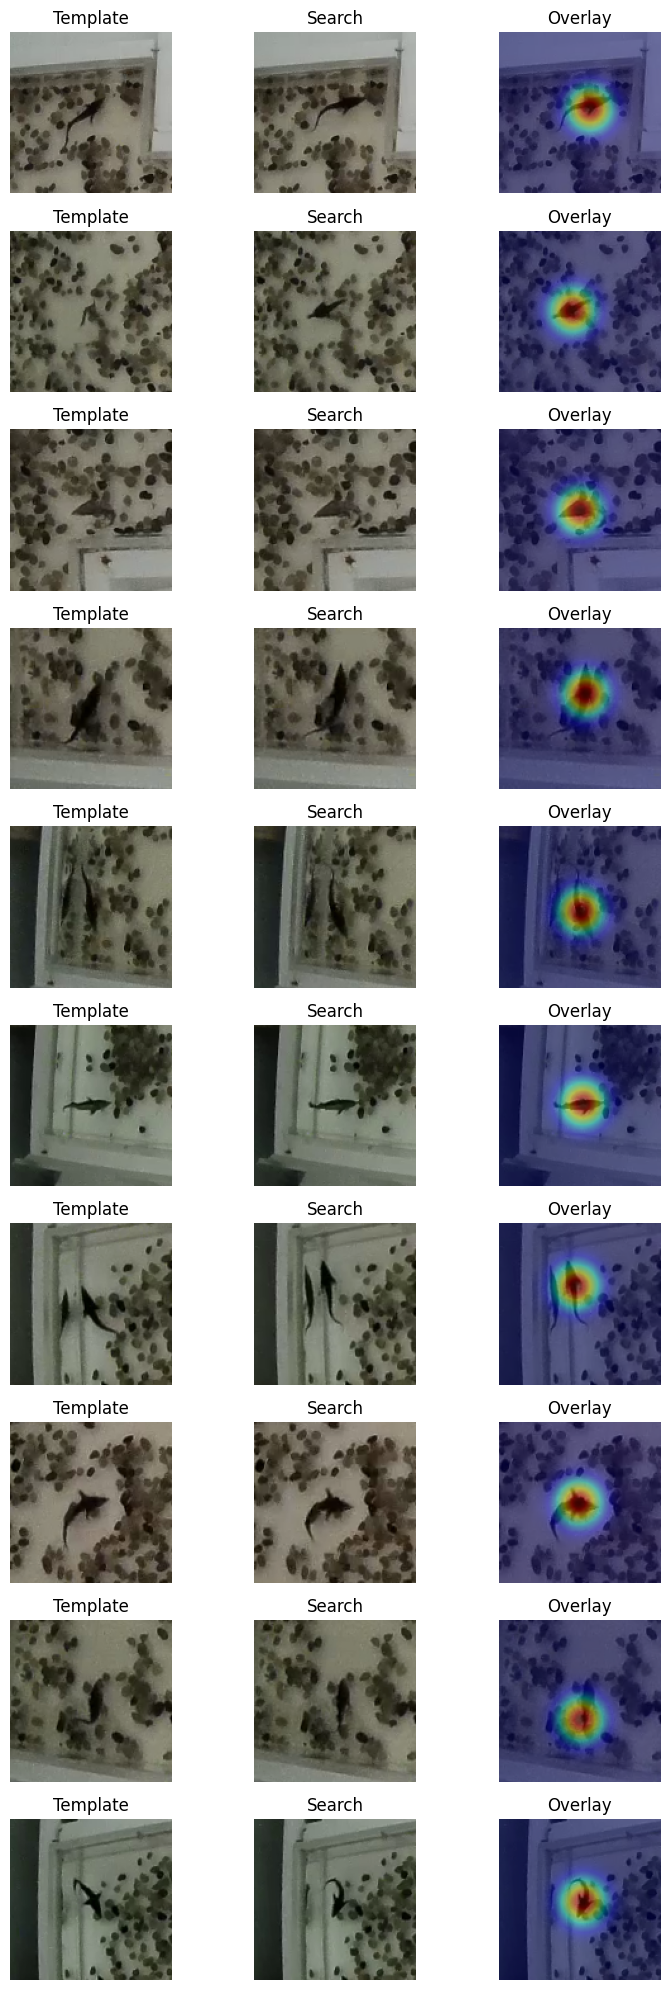

In [5]:
N = 10  # Number of samples to visualize

fig, axes = plt.subplots(N, 3, figsize=(8, 2 * N))

for i in range(N):
    random.seed(i)
    idx = random.randint(0, len(train_dataset) - 1)
    template, search, heatmap = train_dataset[idx]

    template_img = TF.to_pil_image(denormalize(template))
    search_img = TF.to_pil_image(denormalize(search))
    heatmap_np = heatmap.squeeze().numpy()

    # === Resize heatmap
    search_w, search_h = search_img.size  # PIL: size = (W, H)
    heatmap_np = cv2.resize(heatmap_np, (search_w, search_h), interpolation=cv2.INTER_LINEAR)

    # === Normalize heatmap for display
    heatmap_norm = (heatmap_np - heatmap_np.min()) / (heatmap_np.max() - heatmap_np.min() + 1e-8)

    # === Blend
    search_np = TF.to_tensor(search_img).permute(1, 2, 0).numpy()
    heatmap_rgb = plt.cm.jet(heatmap_norm)[..., :3]
    overlay = 0.6 * search_np + 0.4 * heatmap_rgb
    overlay = np.clip(overlay, 0, 1)

    # === Plot
    axes[i, 0].imshow(template_img)
    axes[i, 0].set_title("Template")

    axes[i, 1].imshow(search_img)
    axes[i, 1].set_title("Search")

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Overlay")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Device definition.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Model loaded and moved to device:", device)

# Model settings for training
continue_training = True # Continue training from the latest production model
use_best_model = True # If contnue_training is True, uses the cached best_model.pth, else uses the latest production model.

# Root model path
model_path = "../data/models"

if continue_training:
   if use_best_model:
      # Load the best model
      best_model_path = os.path.join(model_path, "siamese", "best_model.pth")
      assert os.path.exists(best_model_path)

   else:     
      siamese_model_filename = "model_siamese"
      best_model_path = get_latest_model_path(model_path, siamese_model_filename)

   print("Continuing training of the Siamese model from:", best_model_path)

   model = SiameseTracker()
   model.load_state_dict(torch.load(best_model_path, map_location=device))

else:
   efficient_unet_filename = "model_efficient_unet"
   latest_model_stats = get_latest_model_path(model_path, efficient_unet_filename)

   unet = EfficientUNet()
   unet.load_state_dict(torch.load(latest_model_stats, map_location=device))
   unet.eval()

   model = SiameseTracker(unet)

   print("Training a new Siamese model with EfficientNet encoder from:", latest_model_stats)

model.to(device);

Model loaded and moved to device: cuda
Training a new Siamese model with EfficientNet encoder from: ../data/models\model_efficient_unet_2025-05-11.pth


In [7]:



def weighted_bce_with_logits(pred, target, limit=0.5, pos_weight=10.0):
    weights = torch.ones_like(target)
    weights[target > limit] = pos_weight  # emphasize center of Gaussian

    bce = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
    return bce

def get_centroids_per_sample(heatmap):
    b, _, _, w = heatmap.shape
    heatmaps = heatmap.squeeze(1)  # shape: [B, H, W]
    centroids = []

    for i in range(b):
        hm = heatmaps[i]
        hm_sum = hm.mean().item()

        if hm_sum < 1e-8:
            centroids.append(None)
        else:
            flat_idx = torch.argmax(hm)
            y = flat_idx // w
            x = flat_idx % w
            conf = hm[y, x]
            centroids.append((x.float(), y.float(), conf.float()))

    return centroids

def centroid_distance_loss(pred, target):
    preds = get_centroids_per_sample(torch.sigmoid(pred))
    targets = get_centroids_per_sample(target)

    distances = []

    for p, t in zip(preds, targets):
        if p is not None and t is not None:
            x_p, y_p, _ = p
            x_t, y_t, _ = t
            dist = torch.sqrt((x_p - x_t) ** 2 + (y_p - y_t) ** 2 + 1e-8)
            distances.append(dist)

    if not distances:
        return torch.tensor(0.0).to(pred.device), 0

    return torch.stack(distances).mean(), len(distances)

def rgb_consistency_loss(template_img, search_img, pred_heatmap, sigma=2.0, threshold=0.5):
    B, _, H, W = template_img.shape
    device = template_img.device

    # === Upsample predicted heatmap
    pred_heatmap_up = F.interpolate(pred_heatmap, size=(H, W), mode='bilinear', align_corners=False)

    # === Create fixed centered Gaussian for all batch
    grid_y, grid_x = torch.meshgrid(
        torch.linspace(0, H - 1, H, device=device),
        torch.linspace(0, W - 1, W, device=device),
        indexing='ij'
    )
    center_y = (H - 1) / 2
    center_x = (W - 1) / 2
    gaussian = torch.exp(-((grid_x - center_x)**2 + (grid_y - center_y)**2) / (2 * sigma**2))
    gaussian /= gaussian.sum() + 1e-8
    gaussian = gaussian[None, None, :, :]  # shape (1, 1, H, W)

    loss = 0.0
    for i in range(B):
        # === Mask and normalize predicted heatmap
        mask = (pred_heatmap_up[i] > threshold).float()
        weighted_mask = pred_heatmap_up[i] * mask
        weighted_mask /= weighted_mask.sum() + 1e-8  # (1, H, W)

        # === Compute mean RGB in search
        rgb_search = (search_img[i] * weighted_mask).view(3, -1).sum(dim=1)

        # === Compute mean RGB in template using Gaussian
        rgb_template = (template_img[i] * gaussian[0]).view(3, -1).sum(dim=1)

        loss += F.mse_loss(rgb_search, rgb_template)

    return loss / B


In [8]:
model_dir = '../data/models/siamese'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'
epoch_vis = f'{model_dir}/epoch_vis'

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(epoch_vis, exist_ok=True)

In [ ]:
training_stages = [
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
       ],
       "epochs": 5,
       "lr": 1e-5,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            model.up3,
            model.up2,
            model.up1,
            model.up0,
       ],
       "epochs": 3,
       "lr": 1.25e-3,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            model.up3,
            model.up2,
            model.up1,
       ],
       "epochs": 3,
       "lr": 2.5e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
            model.up3,
            model.up2,
       ],
       "epochs": 5,
       "lr": 1e-4,
   },
   {
       "freeze_layers": [
            model.enc1,
            model.enc2,
            model.enc3,
            model.enc4,
       ],
       "epochs": 5,
       "lr": 1e-4,
   },
]

In [10]:
# Training loop
best_val_loss = float('inf')
losses = []

epoch_save_interval = 1

centroid_weight = 0.025  # weight for centroid distance loss
color_weight = 0.005  # weight for color consistency loss
sparsity_weight = 0.001  # weight for sparsity loss


for stage, training_stage in enumerate(training_stages):

    freeze_layers = training_stage["freeze_layers"]
    epochs = training_stage["epochs"]
    lr = training_stage["lr"]

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5,
        patience=3,
    )

    for param in model.parameters():
        param.requires_grad = False

    for layer in model.children():
        if layer not in freeze_layers:
            for param in layer.parameters():
                param.requires_grad = True

    for epoch in range(epochs):
        model.train()

        for layer in freeze_layers:
            layer.eval()

        train_loss = 0.0

        random.seed(time.time())
        train_bar = tqdm(train_loader, desc=f"Stage {stage + 1}, Training {epoch + 1}", leave=False)
        for template, search, heatmap in train_bar:
            template = template.to(device)
            search = search.to(device)
            target = heatmap.to(device)

            output = model(template, search)

            mse = weighted_bce_with_logits(output, target)
            cdist, distances = centroid_distance_loss(output, target)
            rgb_loss = rgb_consistency_loss(template, search, output)
            sparsity_loss = output.pow(2).mean()

            loss = (
                mse
                + centroid_weight * cdist
                + color_weight * rgb_loss
                + sparsity_weight * sparsity_loss
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        model.eval()
        val_loss = 0.0
        val_results = []  # NEW

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Stage {stage + 1}, Validation {epoch + 1}", leave=False)

            for template, search, heatmap in val_bar:
                template = template.to(device)
                search = search.to(device)
                target = heatmap.to(device)

                output = model(template, search)

                mse = weighted_bce_with_logits(output, target)
                cdist, distances = centroid_distance_loss(output, target)
                rgb_loss = rgb_consistency_loss(template, search, output)
                sparsity_loss = output.pow(2).mean()

                loss = (
                    mse
                    + centroid_weight * cdist
                    + color_weight * rgb_loss
                    + sparsity_weight * sparsity_loss
                )

                val_loss += loss.item()
                val_bar.set_postfix(loss=loss.item())

                # --------- COLLECT SAMPLE DATA ---------
                pred = torch.sigmoid(output)

                # Get centroids and confidence per sample
                centroids_pred = get_centroids_per_sample(pred)
                centroids_gt = get_centroids_per_sample(target)

                for i in range(template.size(0)):
                    p = centroids_pred[i]
                    t = centroids_gt[i]

                    if p is None or t is None:
                        continue  # skip bad samples

                    x_pred, y_pred, confidence = p
                    x_gt, y_gt, _ = t

                    xp, yp = x_pred.item(), y_pred.item()
                    xg, yg = x_gt.item(), y_gt.item()

                    dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)

                    val_results.append({
                        'template': template[i].cpu(),
                        'search': search[i].cpu(),
                        'gt_heatmap': target[i, 0].cpu(),
                        'pred_heatmap': pred[i, 0].cpu(),
                        'gt_centroid': (xg, yg),
                        'pred_centroid': (xp, yp),
                        'confidence': confidence.item(),
                        'distance': dist,
                    })

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        losses.append((train_loss, val_loss))

        scheduler.step(val_loss)

        save_epoch_visualization(val_results, stage, epoch, output_dir=epoch_vis, N=10)
        save_epoch_activation_visualization(val_results, model, device, stage, epoch, output_dir=epoch_vis)

        print(f"Epoch {epoch+1}/{epochs} - Train: {train_loss:.4f} | Val: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print("New best model, saving.")
            torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

        if (epoch + 1) % epoch_save_interval == 0:
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))
        


C:\Users\relja\AppData\Local\Temp\ipykernel_145492\2009575410.py:72: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff_norm = np.abs(pred_norm - gt_norm)


Epoch 1/3 - Train: 1.7670 | Val: 1.1333
New best model, saving.


Epoch 2/3 - Train: 0.8809 | Val: 0.8090
New best model, saving.


Epoch 3/3 - Train: 0.7569 | Val: 0.7544
New best model, saving.


Epoch 1/5 - Train: 0.6590 | Val: 0.6642
New best model, saving.


Epoch 2/5 - Train: 0.6127 | Val: 0.6432
New best model, saving.


Epoch 3/5 - Train: 0.5996 | Val: 0.6413
New best model, saving.


Epoch 4/5 - Train: 0.5946 | Val: 0.6376
New best model, saving.


Epoch 5/5 - Train: 0.5965 | Val: 0.6348
New best model, saving.


Epoch 1/5 - Train: 0.4981 | Val: 0.5113
New best model, saving.


Epoch 2/5 - Train: 0.4615 | Val: 0.4977
New best model, saving.


Epoch 3/5 - Train: 0.4561 | Val: 0.4981


Epoch 4/5 - Train: 0.4519 | Val: 0.4952
New best model, saving.


Epoch 5/5 - Train: 0.4492 | Val: 0.4901
New best model, saving.


Epoch 1/5 - Train: 0.4457 | Val: 0.4860
New best model, saving.


Epoch 2/5 - Train: 0.4466 | Val: 0.4834
New best model, saving.


Epoch 3/5 - Train: 0.4409 | Val: 0.4809
New best model, saving.


Epoch 4/5 - Train: 0.4371 | Val: 0.4777
New best model, saving.


Epoch 5/5 - Train: 0.4402 | Val: 0.4777
New best model, saving.


Epoch 1/5 - Train: 0.4375 | Val: 0.4710
New best model, saving.


Epoch 2/5 - Train: 0.4294 | Val: 0.4721


Epoch 3/5 - Train: 0.4220 | Val: 0.4632
New best model, saving.


Epoch 4/5 - Train: 0.4223 | Val: 0.4618
New best model, saving.


Epoch 5/5 - Train: 0.4174 | Val: 0.4607
New best model, saving.


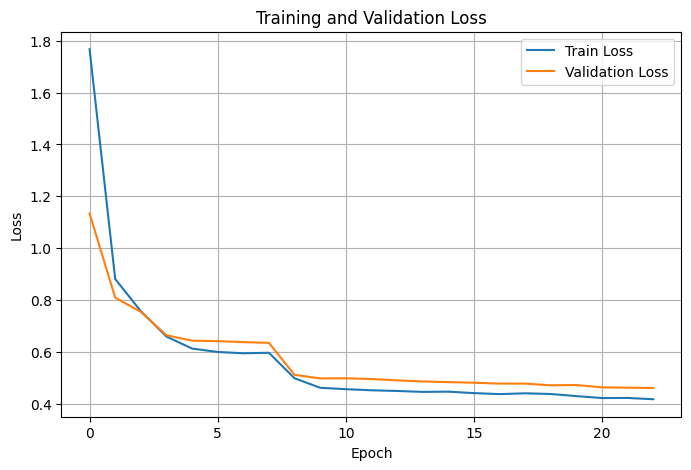

In [11]:
# Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))
model.eval()
model.to(device);

In [13]:
results = []
total_distances = []
total_confidences = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for templates, searches, heatmaps in tqdm(val_loader, desc="Evaluating"):
        templates = templates.to(device)
        searches = searches.to(device)
        heatmaps = heatmaps.to(device)

        preds = torch.sigmoid(model(templates, searches))

        heatmaps = F.interpolate(heatmaps, size=templates.shape[2:], mode='bilinear', align_corners=False)
        preds = F.interpolate(preds, size=templates.shape[2:], mode='bilinear', align_corners=False)

        centroids_pred = get_centroids_per_sample(preds)
        centroids_gt = get_centroids_per_sample(heatmaps)

        for i in range(len(templates)):
            p = centroids_pred[i]
            t = centroids_gt[i]

            if p is None or t is None:
                continue

            x_pred, y_pred, confidence = p
            x_gt, y_gt, _ = t

            xp, yp = x_pred.item(), y_pred.item()
            xg, yg = x_gt.item(), y_gt.item()

            confidence = confidence.item()

            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)
            total_distances.append(dist)
            total_confidences.append(confidence)

            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

            img = searches[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'confidence': confidence,
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
avg_conf = np.mean(total_confidences)
print(f"\nAverage centroid distance: {avg_dist:.2f} px, Average confidence: {avg_conf:.2f}")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")


Evaluating: 100%|██████████| 32/32 [00:09<00:00,  3.51it/s]


Average centroid distance: 4.94 px, Average confidence: 0.91
Within 3px: 34.12%
Within 5px: 65.88%
Within 10px: 92.16%


In [14]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']
    conf = result['confidence']

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    xc, yc = img_disp.shape[1] // 2, img_disp.shape[0] // 2

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT', marker='o')
    axs[0].scatter([xp], [yp], c='red', label='Pred', marker='o')
    axs[0].scatter([xc], [yc], c='green', label='Template', marker='x')
    
    axs[0].set_title(f'Image (Err: {dist:.1f}px, Conf: {conf:.2f})')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()

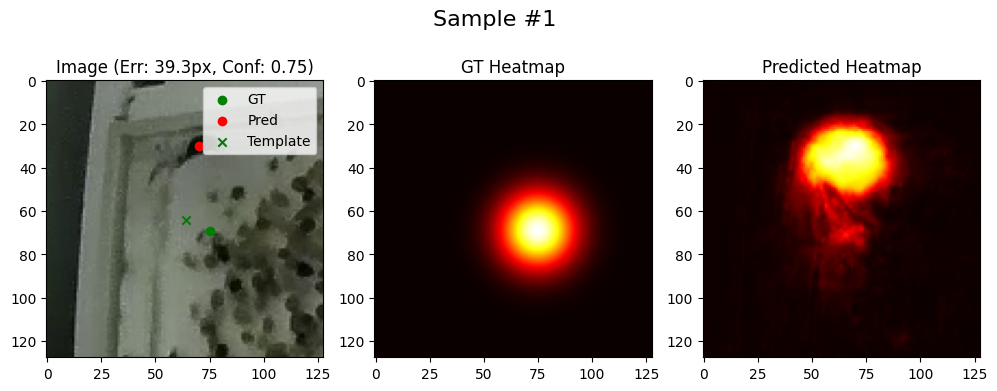

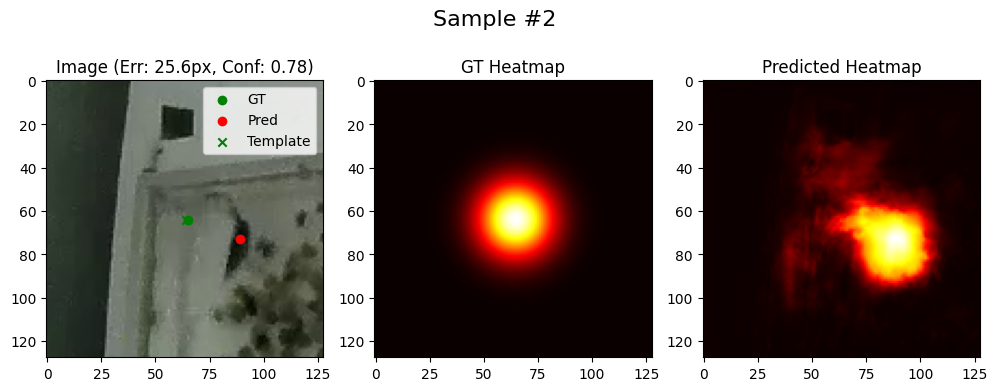

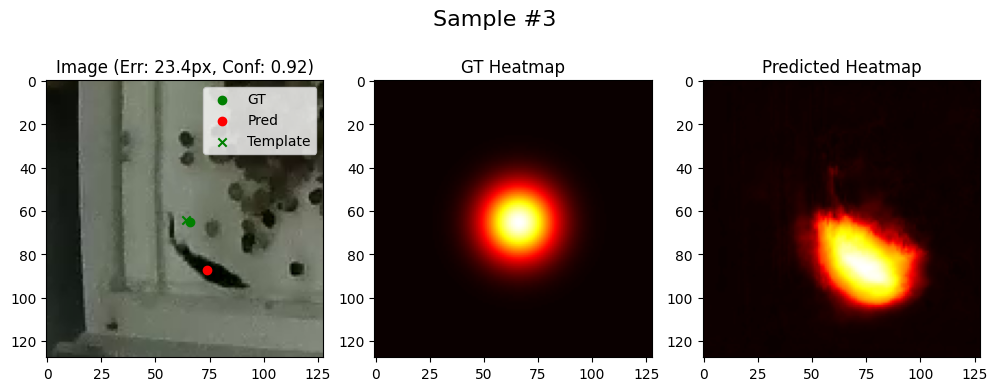

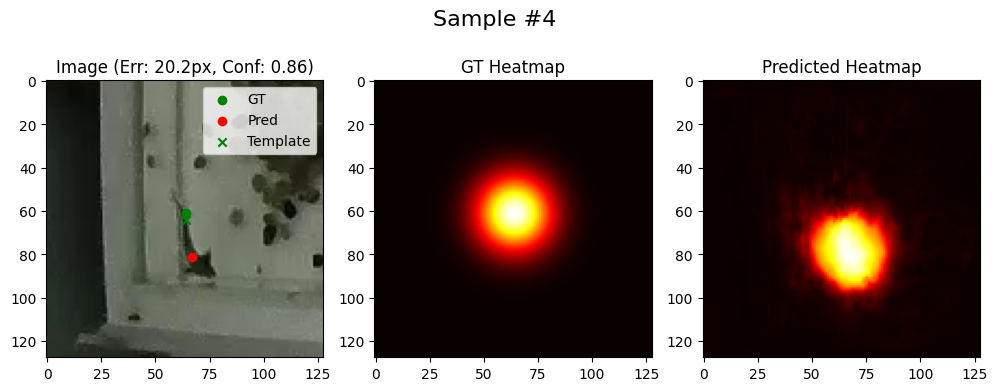

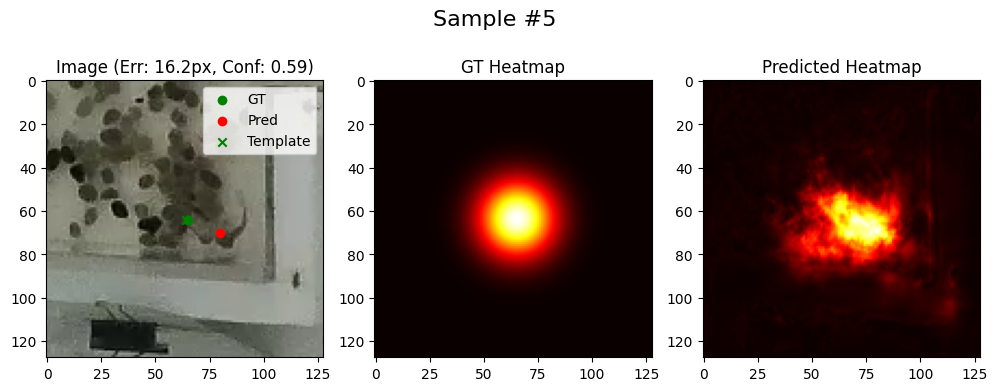

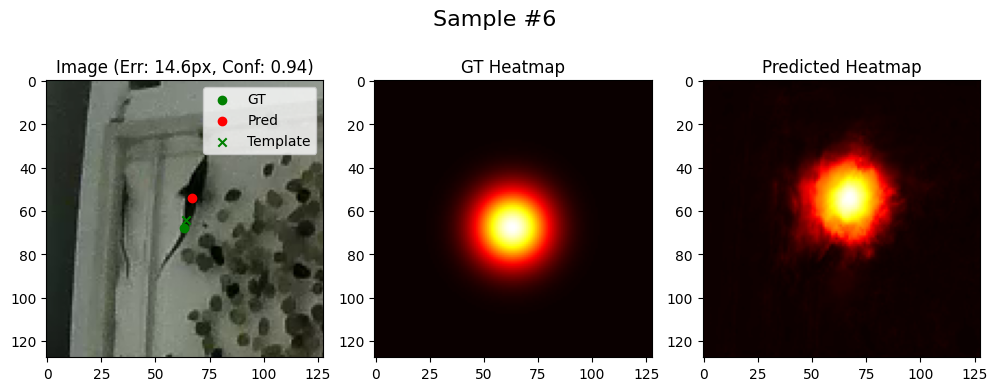

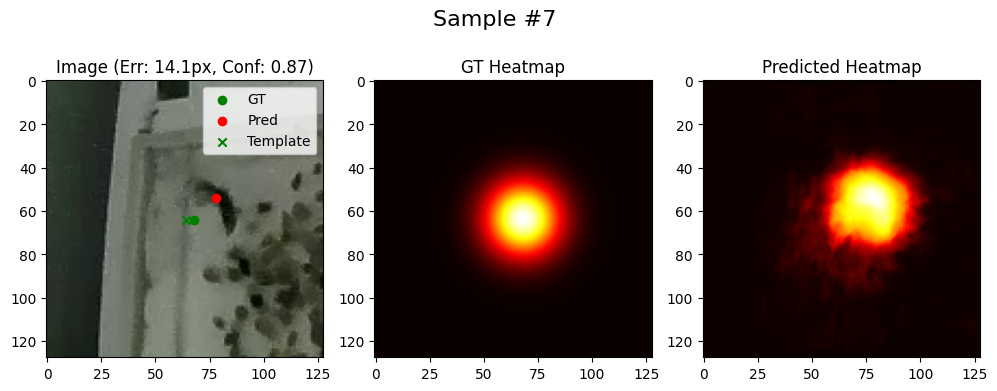

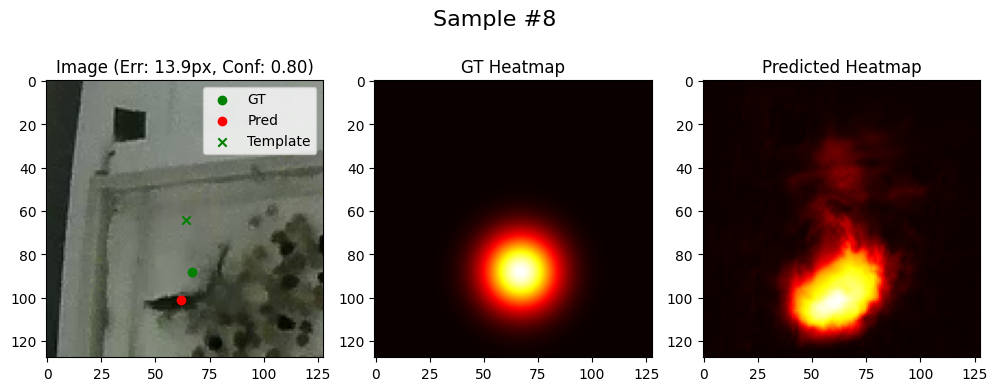

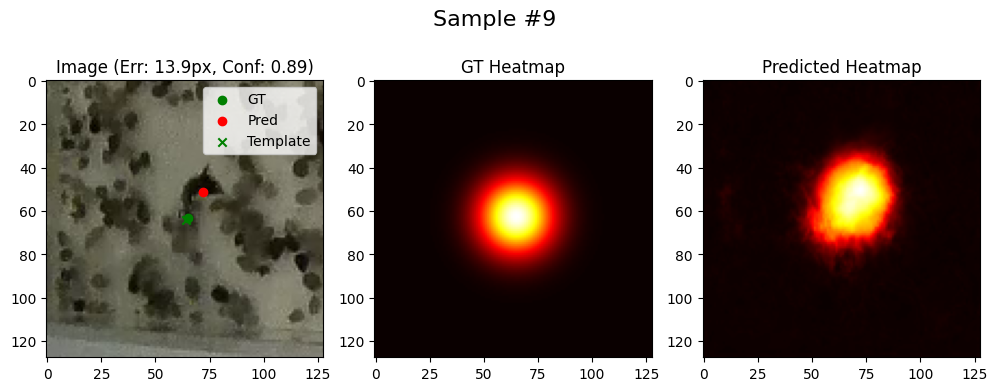

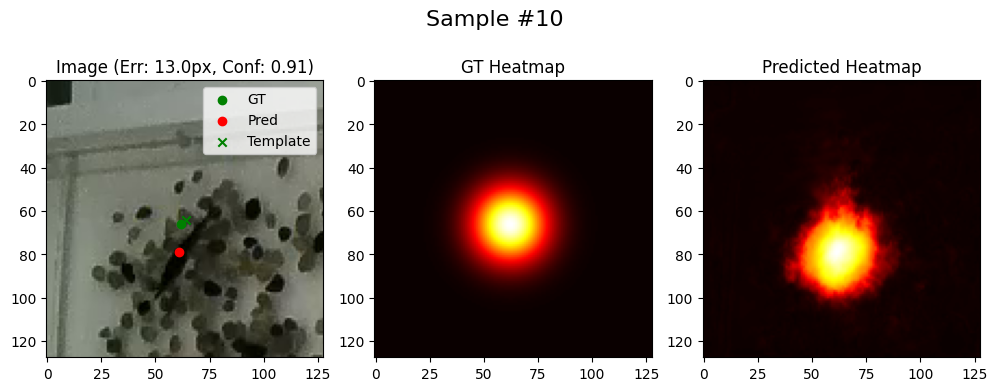

In [15]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

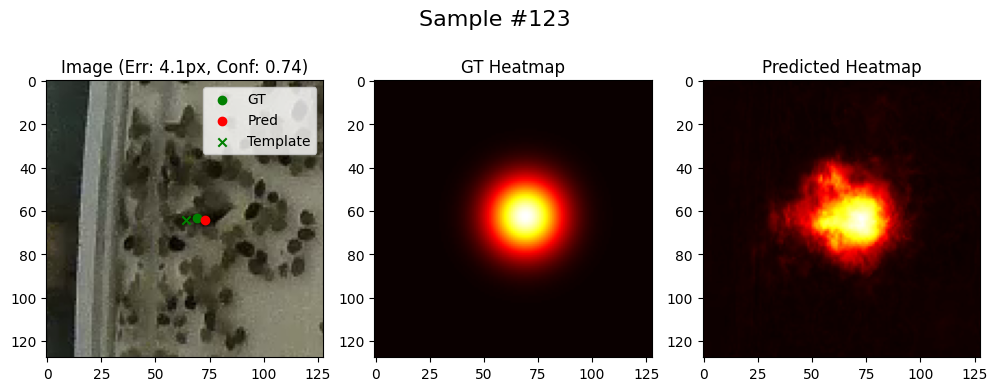

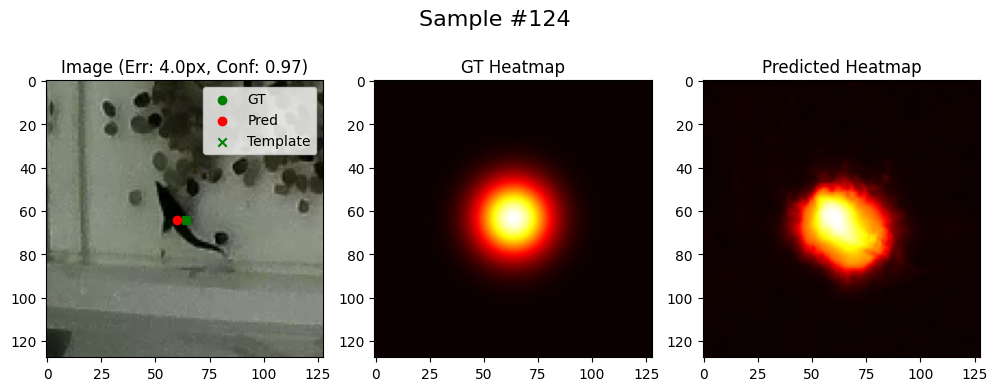

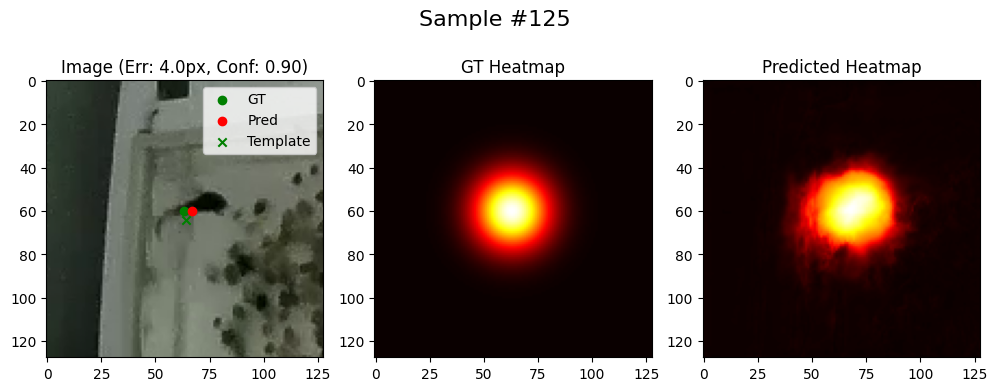

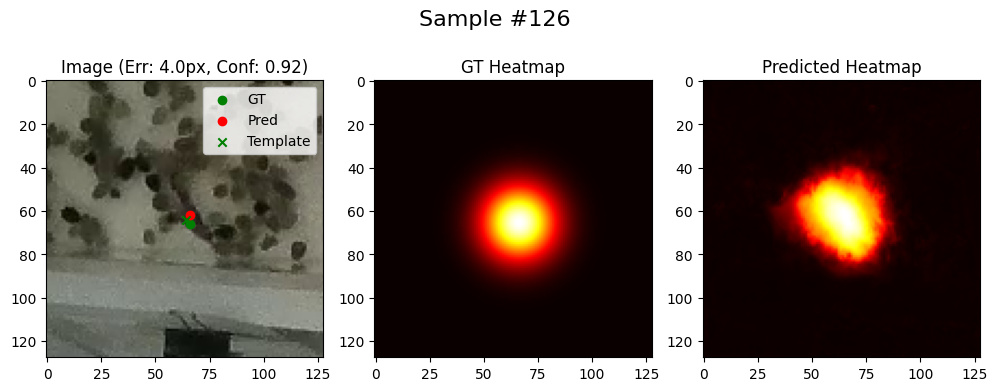

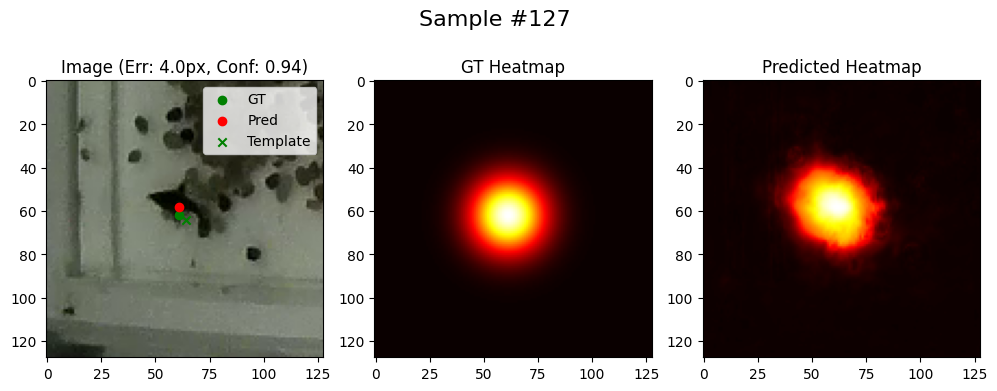

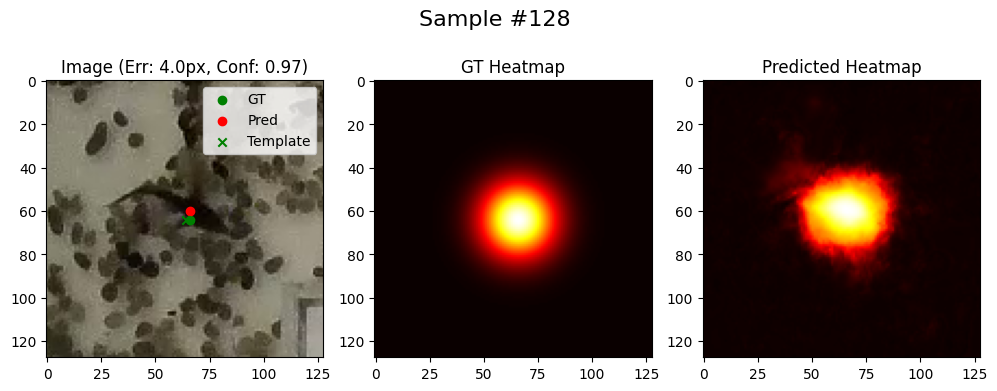

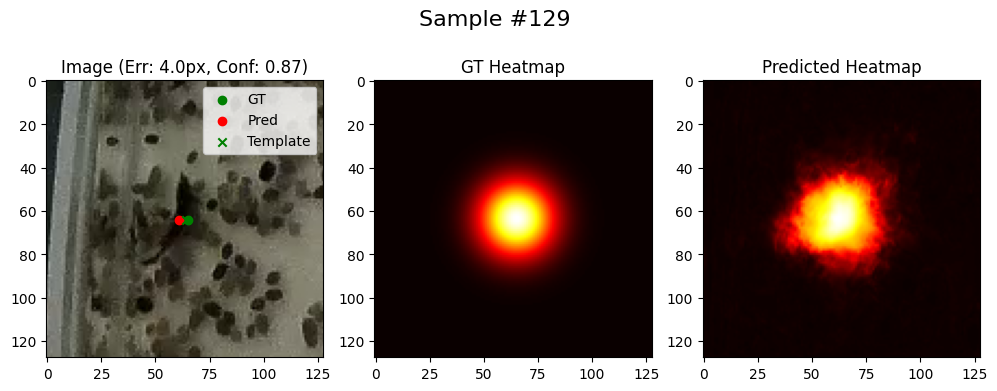

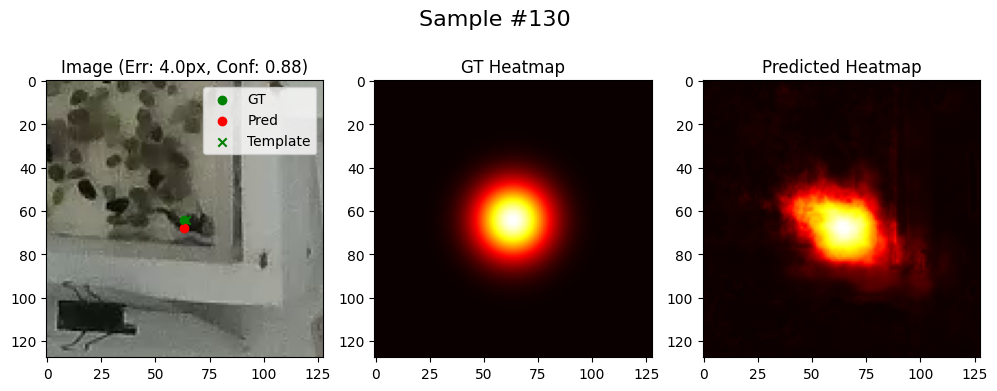

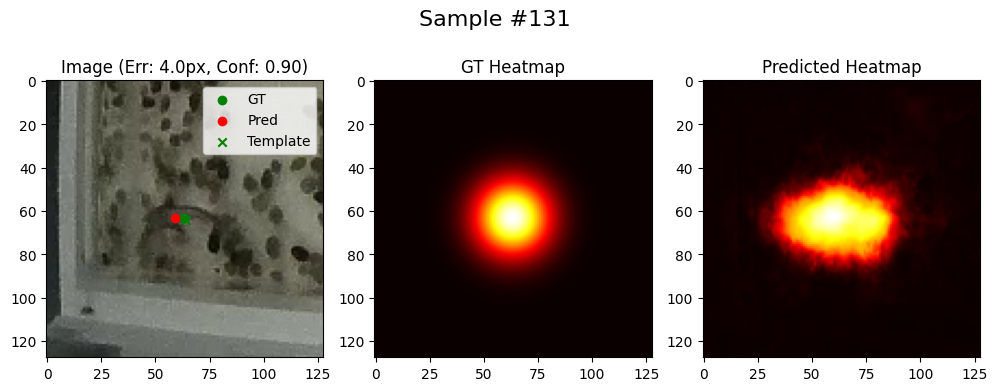

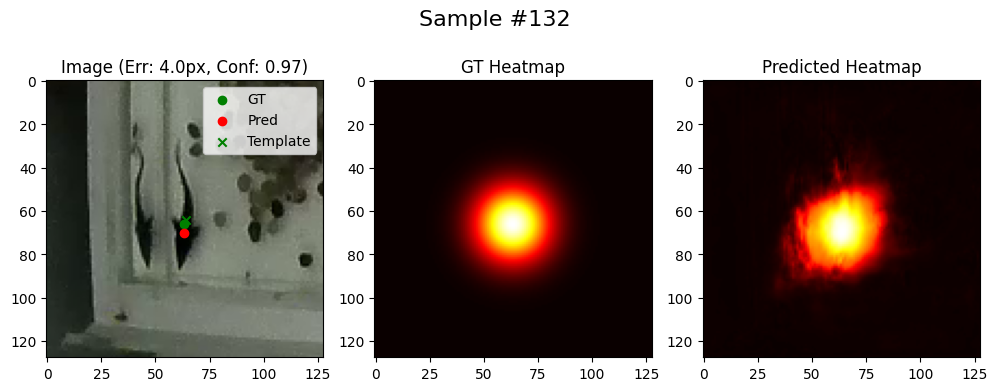

In [16]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

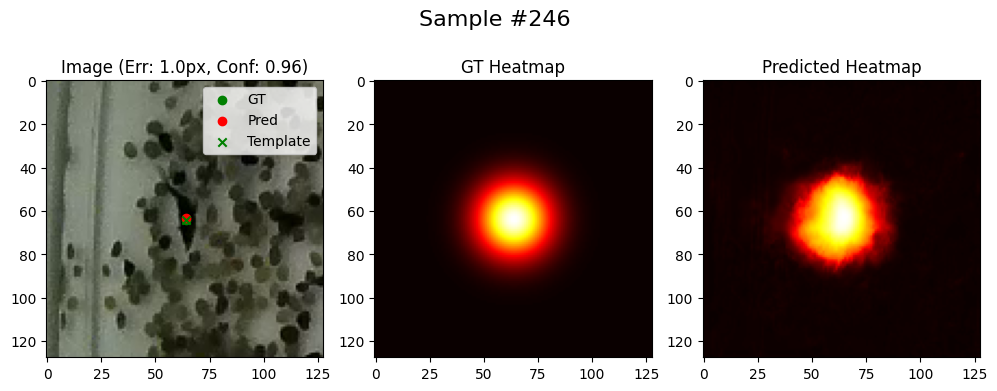

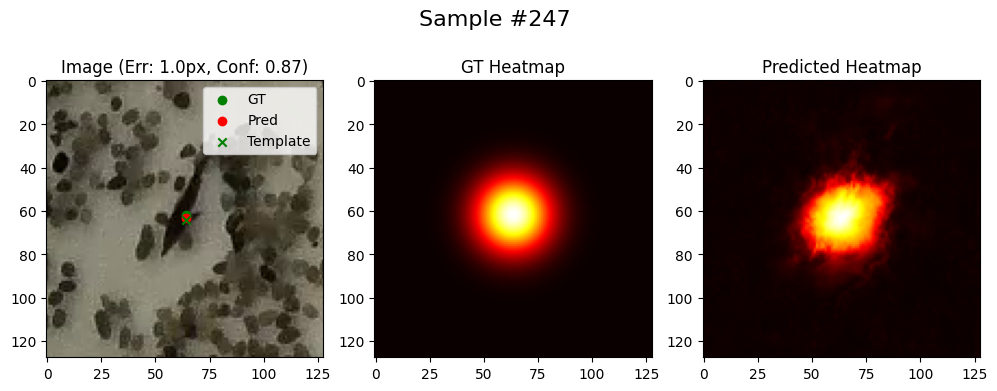

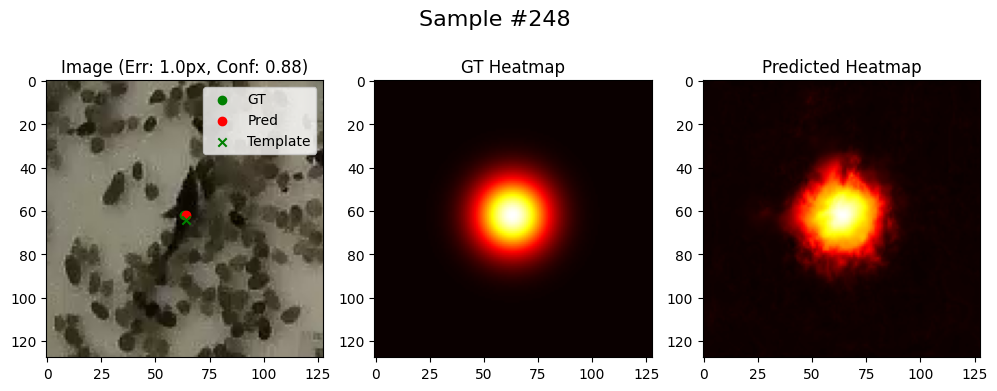

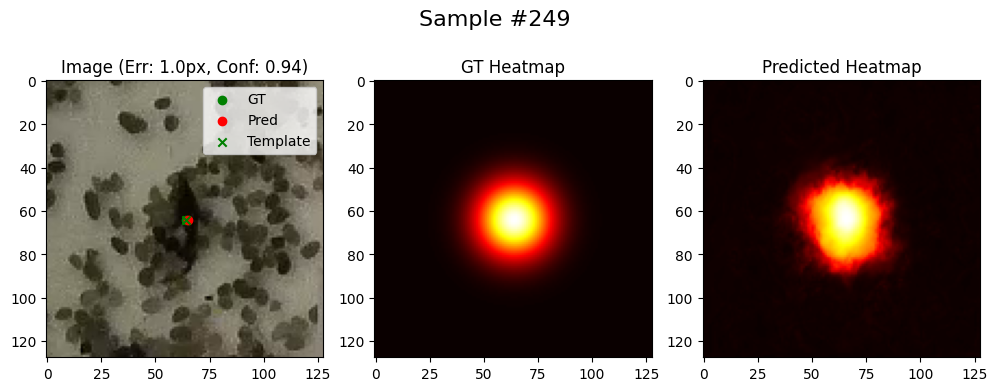

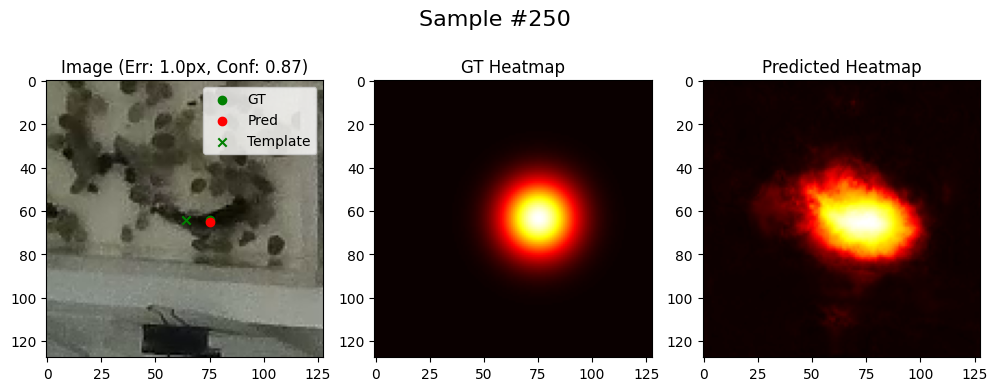

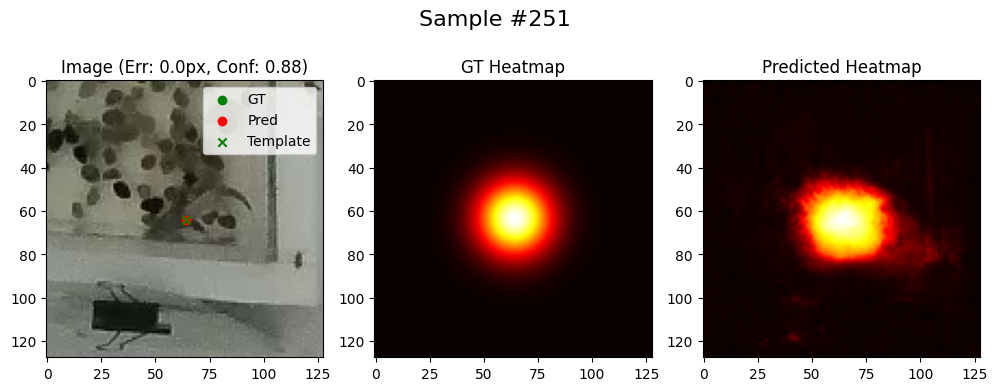

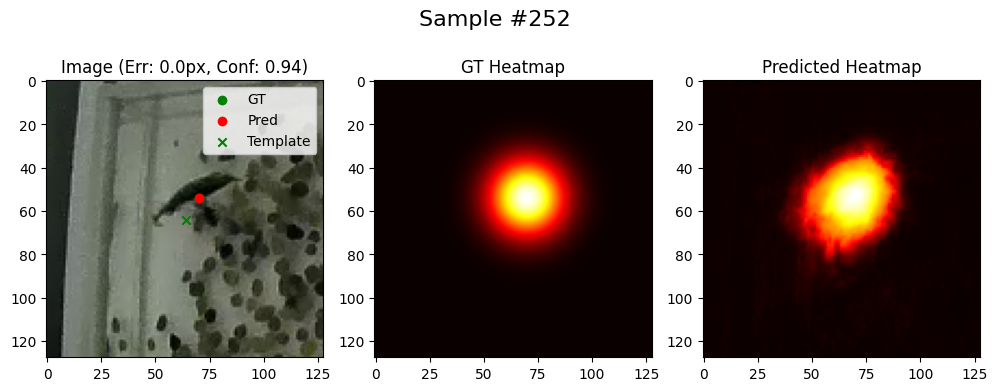

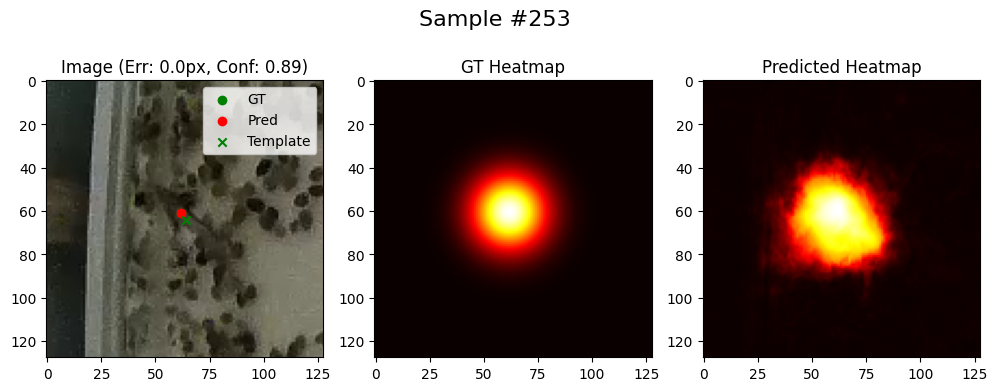

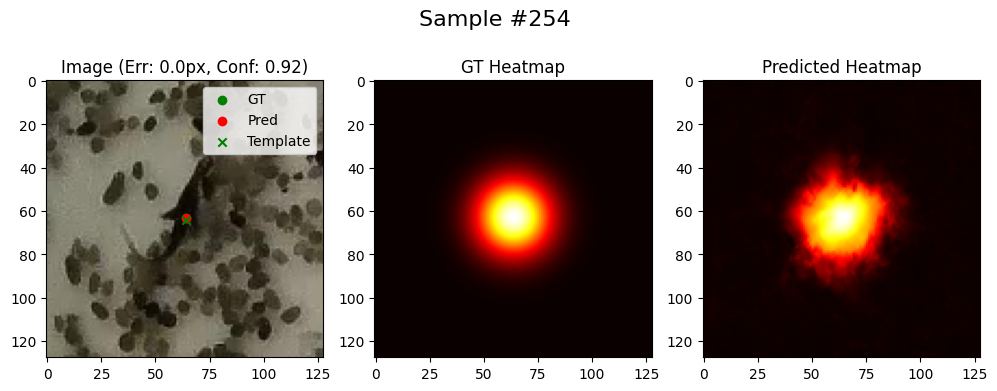

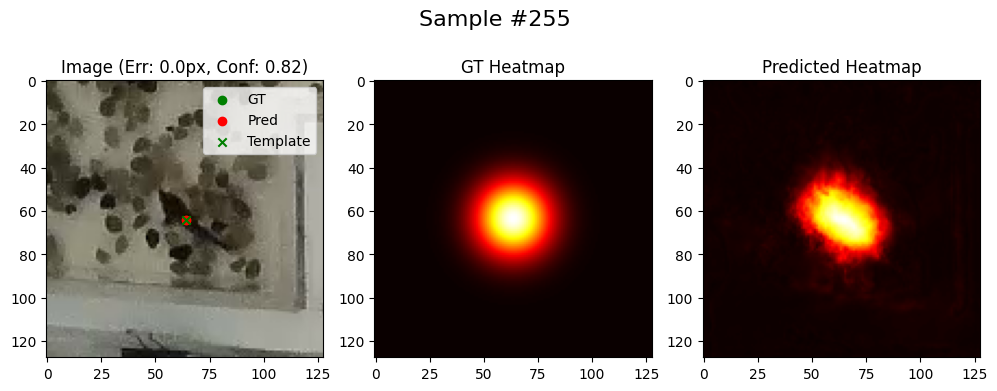

In [17]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)